In [1]:
from darts import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
import os
from darts.utils.statistics import extract_trend_and_seasonality
from darts.utils.utils import ModelMode
from darts.models import CatBoostModel
#from darts.metrics import mape
import numpy as np
import optuna
from darts.utils.statistics import plot_residuals_analysis
from darts.utils.missing_values import fill_missing_values
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import MinMaxScaler
from darts.utils.timeseries_generation import constant_timeseries

C:\Users\aryck\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def mape(y_true, y_pred):
    """
    Calcula o MAPE (Erro Percentual Absoluto Médio) entre duas séries temporais.

    Parâmetros:
    - y_true: array-like, série temporal original.
    - y_pred: array-like, série temporal prevista.

    Retorna:
    - MAPE: float, valor do MAPE.
    """
    # Converte as séries temporais para arrays numpy
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    

    # Calcula o MAPE
    mape_value = round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100,2)

    return mape_value

In [3]:
series = pd.read_csv("data/series_total.csv")
weekly_cases = pd.read_csv("data/weekly_cases.csv")

def train_test_splits(series, train_proportion_list):
    '''
    Funcao para dividir a serie temporal em treino e teste
    
    Parametros:
    
    *series: serie que sera particionada em treino e validacao.
    *train_proportion_list: Lista que define a proporcao do conjunto
    de treinamento. Ex: series_list = [0.8,0.5] significa primeiro conjunto 
    de treino com 80% dos dados totais e o segundo com 50% dos dados totais.
    '''
    partitions_dict = {'train': [], 'test': []}

    for i, train_proportion in enumerate(train_proportion_list):
        train_size = int(len(series) * train_proportion)
        train, test = series.split_before(train_size)
        partitions_dict['train'].append(train)
        partitions_dict['test'].append(test)

        print(f'Partition {i+1} - Train size: {len(train)}, Test size: {len(test)}, Total size: {len(train)+len(test)}')

    return partitions_dict

In [4]:
# 1. Converter a coluna de data para datetime
weekly_cases["Epi_Date"] = pd.to_datetime(weekly_cases["Epi_Date"])

# 2. Ordenar por data, se necessário
weekly_cases = weekly_cases.sort_values("Epi_Date")

# 3. Criar objeto TimeSeries com a coluna "Number"
ts_weekly_cases = TimeSeries.from_dataframe(weekly_cases, time_col="Epi_Date", value_cols="Number")


In [35]:
## Normalizando os dados

SRAG_scaler = Scaler()
srag_series_scaled = SRAG_scaler.fit_transform(ts_weekly_cases)

srag_train , srag_val = srag_series_scaled.split_before(0.75)

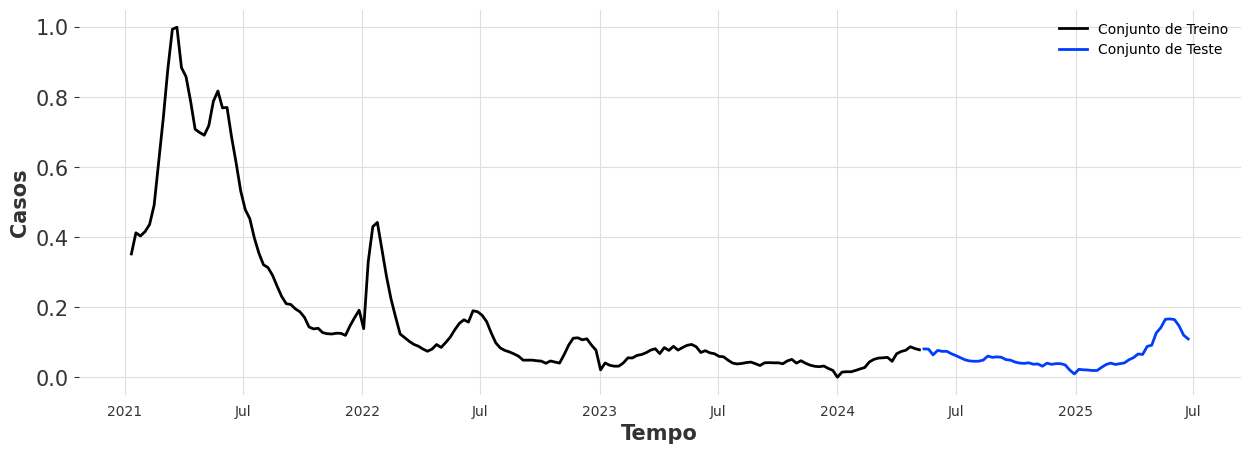

In [36]:
figure = plt.figure(figsize=(15, 5))
srag_train.plot(label = 'Conjunto de Treino')
srag_val.plot(label = 'Conjunto de Teste')
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 15)
plt.xlabel('Tempo', fontsize = 15)
plt.ylabel('Casos', fontsize = 15)
plt.legend()
plt.show()

In [8]:
pip install neuralforecast

  Using cached sympy-1.13.1-py3-none-any.whl.metadata (12 kB)
   ---------------------------------------- 0.0/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/204.1 MB ? eta -:--:--
   ---------------------------------------- 0.5/204.1 MB 762.0 kB/s eta 0:04:28
   ---------------------------------------- 0.8/204.1 MB 932.9 kB/s eta 0:03:38
   ---------------------------------------- 1.3/204.1 MB 1.3 MB/s eta 0:02:35
   ---------------------------------------- 1.8/204.1 MB 1.6 MB/s eta 0:02:07
    --------------------------------------- 2.6/204.1 MB 1.9 MB/s eta 0:01:49
    --------------------------------------- 3.1/204.1 MB 2.1 MB/s eta 0:01:38
    --------------------------------------- 3.9/204.1 MB 2.2 MB/s eta 0:01:32
    --------------------------------------- 4.5/204.1 MB 2.2 MB/s eta 0:01:31
   - -------------------------------------- 5.2/204.1 MB 2.4 MB/s eta 0:01:25
   - --------------

  You can safely remove it manually.


In [9]:
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS,PatchTST,LSTM, NHITS
from neuralforecast.losses.pytorch import MQLoss,MAPE
from neuralforecast.losses.pytorch import MAE
from neuralforecast.auto import AutoPatchTST,AutoNHITS
from ray.tune.search.hyperopt import HyperOptSearch
from sklearn.preprocessing import StandardScaler
from ray import tune

2025-07-11 01:56:59,301	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-07-11 01:56:59,867	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [10]:
weekly_cases

,Epi_Date,Epi_Year,Epi_Week,Number
0,2021-01-11,2021,2,26675
1,2021-01-18,2021,3,30976
2,2021-01-25,2021,4,30338
3,2021-02-01,2021,5,31220
4,2021-02-08,2021,6,32690
...,...,...,...,...
228,2025-05-26,2025,22,13435
229,2025-06-02,2025,23,13292
230,2025-06-09,2025,24,12003
231,2025-06-16,2025,25,10120


In [11]:
from sklearn.preprocessing import MinMaxScaler

# Definindo o índice de divisão
split_index = int(0.75 * len(weekly_cases))


# Separando e escalando 'Preço Médio'
df = weekly_cases[['Epi_Date', 'Number']].copy()
df['ID'] = 'numero'
df.rename(columns={'Number': 'y'}, inplace=True)
df.rename(columns={'Epi_Date': 'Date'}, inplace=True)


scaler_preco = MinMaxScaler()
df['y'] = scaler_preco.fit_transform(df[['y']])

# Dividindo o conjunto de dados para treino e validação em 'Preço Médio'
train_df = df[:split_index]
val_df = df[split_index:]

# Concatenando todos os dataframes em Y_df
Y_df = pd.concat([train_df], ignore_index=True)
Y_df

,Date,y,ID
0,2021-01-11,0.352242,numero
1,2021-01-18,0.412542,numero
2,2021-01-25,0.403598,numero
3,2021-02-01,0.415963,numero
4,2021-02-08,0.436573,numero
...,...,...,...
169,2024-04-08,0.073522,numero
170,2024-04-15,0.077111,numero
171,2024-04-22,0.087023,numero
172,2024-04-29,0.081948,numero


In [26]:
def objective(trial):
    global predictions

    k = trial.suggest_int('k',1,20)
    
    models = [PatchTST(h=len(val_df)+32,
                  encoder_layers = k,    
                  n_heads = k,
                  hidden_size=2*k,      
                  learning_rate = trial.suggest_float('lr',0.001,0.01),
                  patch_len = trial.suggest_int('patch_len',32,256),    
                  batch_size = trial.suggest_categorical('batch_size',[2,4,8,16]),
                  activation = 'relu',   
                  dropout = trial.suggest_float('dropout',0.25,0.40),          
                  max_steps=200,
                  loss=MQLoss(level=[80]),
                  input_size=trial.suggest_int('input_size',32,368),   
                  random_seed=48,
                  start_padding_enabled=True
                  )]
    nf = NeuralForecast(
        models = models, 
        freq='W'
    )

    nf.fit(
    df = Y_df,
    time_col='Date',
    target_col='y',
    id_col='ID',
    verbose=True
   )

    predictions = nf.predict(train_df)
    predictions = predictions.reset_index()
    val_predictions = predictions[predictions['Date'] <= val_df['Date'].values[-1]]
    mape_pred = mape(val_df['y'].values,val_predictions['PatchTST-median'].values)
    # if any(x<0.2 for x in predictions['PatchTST-median']):
    #     mape_pred = 1000
    return mape_pred

def callback(study,trial):
    global best_prediction
    if study.best_trial == trial:
        best_prediction = predictions

study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 50, callbacks = [callback])

[I 2025-07-11 03:10:27,842] A new study created in memory with name: no-name-03f918f0-21e8-497b-8e72-3d3d8c27619c
Seed set to 48
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MQLoss            | 3      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 445 K  | train
-----------------------------------------------------------
445 K     Trainable params
18        Non-trainable params
445 K     Total params
1.780     Total estimated model params size (MB)
390       Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████████| 1/1 [00:02<00:00,  0.35it/s, v_num=137, train_loss_step=0.0646, train_loss_epoch=0.0581]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████████| 1/1 [00:03<00:00,  0.32it/s, v_num=137, train_loss_step=0.046, train_loss_epoch=0.0499]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|███████████████| 1/1 [00:03<00:00,  0.31it/s, v_num=137, train_loss_step=0.046, train_loss_epoch=0.046]

`Trainer.fit` stopped: `max_steps=200` reached.


Epoch 199: 100%|███████████████| 1/1 [00:03<00:00,  0.31it/s, v_num=137, train_loss_step=0.046, train_loss_epoch=0.046]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 40.64it/s]

[I 2025-07-11 03:19:46,303] Trial 0 finished with value: 138.82 and parameters: {'k': 15, 'lr': 0.0062956009585262256, 'patch_len': 151, 'batch_size': 2, 'dropout': 0.36876282201492216, 'input_size': 281}. Best is trial 0 with value: 138.82.
Seed set to 48
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MQLoss            | 3      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 6.9 K  | train
-----------------------------------------------------------
6.9 K     Trainable params
5         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)
65        Modules in train mode
0         Modules in eval mode



Epoch 99: 100%|██████████████| 1/1 [00:00<00:00, 34.47it/s, v_num=139, train_loss_step=0.0503, train_loss_epoch=0.0584]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|█████████████| 1/1 [00:00<00:00, 32.25it/s, v_num=139, train_loss_step=0.0467, train_loss_epoch=0.0468]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|█████████████| 1/1 [00:00<00:00, 21.17it/s, v_num=139, train_loss_step=0.0467, train_loss_epoch=0.0467]

`Trainer.fit` stopped: `max_steps=200` reached.


Epoch 199: 100%|█████████████| 1/1 [00:00<00:00, 19.90it/s, v_num=139, train_loss_step=0.0467, train_loss_epoch=0.0467]

GPU available: False, used: False


TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 124.23it/s]

[I 2025-07-11 03:19:53,846] Trial 1 finished with value: 177.99 and parameters: {'k': 2, 'lr': 0.007533999849938651, 'patch_len': 190, 'batch_size': 16, 'dropout': 0.35278401275498267, 'input_size': 182}. Best is trial 0 with value: 138.82.
Seed set to 48


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MQLoss            | 3      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 321 K  | train
-----------------------------------------------------------
321 K     Trainable params
14        Non-trainable params
321 K     Total params
1.284     Total estimated model params size (MB)
290       Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|██████████████| 1/1 [00:02<00:00,  0.38it/s, v_num=141, train_loss_step=0.0549, train_loss_epoch=0.0436]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 118:   0%|                     | 0/1 [00:00<?, ?it/s, v_num=141, train_loss_step=0.0392, train_loss_epoch=0.0392]


Detected KeyboardInterrupt, attempting graceful shutdown ...
[W 2025-07-11 03:25:37,806] Trial 2 failed with parameters: {'k': 11, 'lr': 0.0023016075744786684, 'patch_len': 79, 'batch_size': 2, 'dropout': 0.3161016207171145, 'input_size': 290} because of the following error: NameError("name 'exit' is not defined").
Traceback (most recent call last):
  File "C:\Python312\Lib\site-packages\pytorch_lightning\trainer\call.py", line 48, in _call_and_handle_interrupt
    return trainer_fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Python312\Lib\site-packages\pytorch_lightning\trainer\trainer.py", line 599, in _fit_impl
    self._run(model, ckpt_path=ckpt_path)
  File "C:\Python312\Lib\site-packages\pytorch_lightning\trainer\trainer.py", line 1012, in _run
    results = self._run_stage()
              ^^^^^^^^^^^^^^^^^
  File "C:\Python312\Lib\site-packages\pytorch_lightning\trainer\trainer.py", line 1056, in _run_stage
    self.fit_loop.run()
  File "C:\Python312\Lib

NameError: name 'exit' is not defined

{'k': 9, 'lr': 0.006654799256502535, 'patch_len': 33, 'batch_size': 4, 'dropout': 0.2526549315778328, 'input_size': 62}


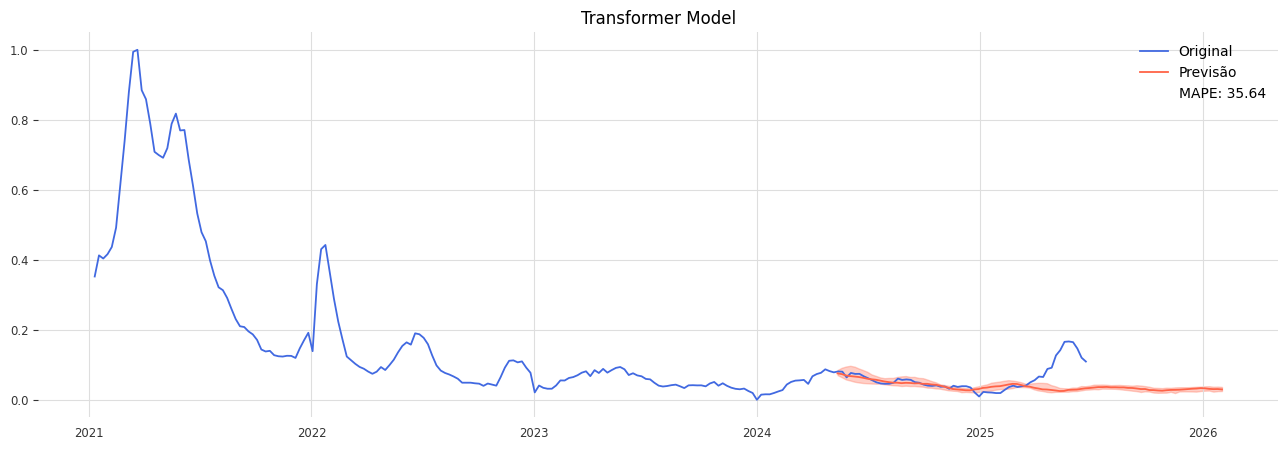

In [20]:
print(study.best_params)
# with open('parametros_completo.txt', 'w') as arquivo:
#     arquivo.write(str(study.best_params))

val_predictions = best_prediction[best_prediction['Date'] <= val_df['Date'].values[-1]]
mape_pred = mape(val_df['y'].values,val_predictions['PatchTST-median'].values)

fig = plt.figure(figsize=(16,5))
plt.title('Transformer Model')
plt.plot(df['Date'],df['y'],label='Original',color = 'royalblue')
plt.plot(best_prediction['Date'],best_prediction['PatchTST-median'],label='Previsão',color = 'tomato')
plt.fill_between(best_prediction['Date'],best_prediction['PatchTST-lo-80'],best_prediction['PatchTST-hi-80'],color='tomato',alpha=0.3)
plt.plot([],[],' ',label=f'MAPE: {mape_pred}')
plt.legend()
plt.show()

In [28]:
# Parâmetros
encoder_layers = 9
learning_rate = 0.006654799256502535
patch_len = 33
batch_size = 4
dropout = 0.2526549315778328
input_size = 62

# Modelo PatchTST com parâmetros fixos
models = [PatchTST(
    h=len(val_df) + 50,
    encoder_layers=k,
    n_heads=k,
    hidden_size=2 * k,
    learning_rate=lr,
    patch_len=patch_len,
    batch_size=batch_size,
    activation='relu',
    dropout=dropout,
    max_steps=200,
    loss=MQLoss(level=[80]),
    input_size=input_size,
    random_seed=48,
    start_padding_enabled=True
)]

# Instanciar e treinar o modelo
nf = NeuralForecast(
    models=models,
    freq='W'
)

nf.fit(
    df=Y_df,
    time_col='Date',
    target_col='y',
    id_col='ID',
    verbose=True
)

# Fazer previsões
predictions = nf.predict(train_df).reset_index()

# Obter previsões para o conjunto de validação
val_predictions = predictions[predictions['Date'] <= val_df['Date'].values[-1]]

# Calcular MAPE
mape_pred = mape(val_df['y'].values, val_predictions['PatchTST-median'].values)

Seed set to 48
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name         | Type              | Params | Mode 
-----------------------------------------------------------
0 | loss         | MQLoss            | 3      | train
1 | padder_train | ConstantPad1d     | 0      | train
2 | scaler       | TemporalNorm      | 0      | train
3 | model        | PatchTST_backbone | 128 K  | train
-----------------------------------------------------------
128 K     Trainable params
12        Non-trainable params
128 K     Total params
0.515     Total estimated model params size (MB)
240       Modules in train mode
0         Modules in eval mode


Epoch 99: 100%|███████████████| 1/1 [00:00<00:00,  1.77it/s, v_num=142, train_loss_step=0.0431, train_loss_epoch=0.041]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████████| 1/1 [00:00<00:00,  1.76it/s, v_num=142, train_loss_step=0.033, train_loss_epoch=0.0332]
Validation: |                                                                                    | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|███████████████| 1/1 [00:00<00:00,  1.66it/s, v_num=142, train_loss_step=0.033, train_loss_epoch=0.033]

`Trainer.fit` stopped: `max_steps=200` reached.


Epoch 199: 100%|███████████████| 1/1 [00:00<00:00,  1.66it/s, v_num=142, train_loss_step=0.033, train_loss_epoch=0.033]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Predicting DataLoader 0: 100%|███████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.63it/s]


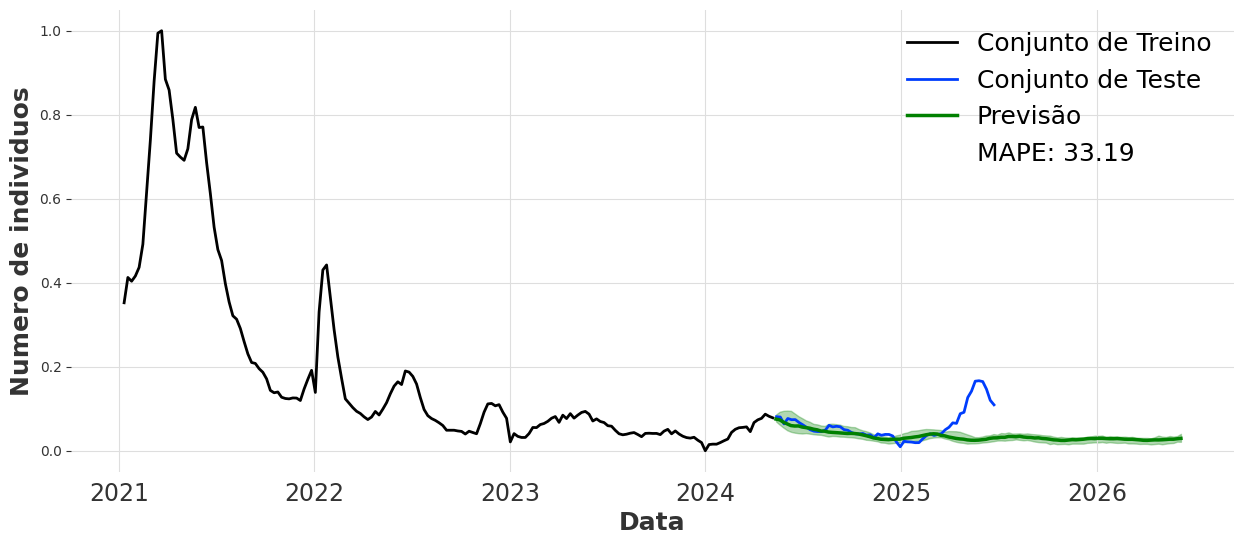

In [37]:
val_predictions = predictions[predictions['Date'] <= val_df['Date'].values[-1]]
mape_pred = mape(val_df['y'].values,val_predictions['PatchTST-median'].values)

fig = plt.figure(figsize=(15,6))
# plt.title('Transformer Model')
# plt.plot(df['Date'],df['y'],label='Original',color = 'black', linewidth=2.5)
srag_train.plot(label = 'Conjunto de Treino')
srag_val.plot(label = 'Conjunto de Teste')
plt.plot(predictions['Date'],predictions['PatchTST-median'],label='Previsão',color = 'green', linewidth=2.5)
plt.fill_between(predictions['Date'],predictions['PatchTST-lo-80'],predictions['PatchTST-hi-80'],color='green',alpha=0.3)
plt.plot([],[],' ',label=f'MAPE: {mape_pred}')
plt.xlabel("Data", fontsize=18)
plt.ylabel("Numero de individuos", fontsize=18)
# plt.title("Intervalo de confiança")
plt.legend(fontsize=18)
plt.xticks(fontsize = 17)
plt.yticks(fontsize = 10)
plt.show()

In [42]:
# Selecionando as colunas normalizadas
cols_to_inverse = ['PatchTST-median', 'PatchTST-lo-80', 'PatchTST-hi-80']

# Aplicando a transformada inversa
predictions[cols_to_inverse] = scaler_preco.inverse_transform(predictions[cols_to_inverse])

# Verificando o resultado
predictions.head()

,index,ID,Date,PatchTST-median,PatchTST-lo-80,PatchTST-hi-80
0,0,numero,2024-05-12,6923.636230,6520.145508,7697.760742
1,1,numero,2024-05-19,6792.259766,5964.235352,8171.550293
2,2,numero,2024-05-26,6397.437012,5466.615234,8326.913086
3,3,numero,2024-06-02,6099.035156,5020.871094,8367.543945
4,4,numero,2024-06-09,5819.455078,4758.235840,8319.302734


In [43]:

predictions.to_csv("patchtst.csv", index=True)